## Project Description

This project is about building a system to recommend healthy ingredients to food.com users based on their past recipe reviews. The food.com team wants to provide their users with the Top-N ingredients and include recipes that match the ingredient list. Additionally, the user should be able to replace specific ingredients with relevant alternatives.

### Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack, csr_matrix
from scipy.stats import randint
import difflib
import string
import spacy
import ast
import itertools
import re
import random

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from surprise import Dataset, Reader, SVD, CoClustering, accuracy, BaselineOnly, KNNBasic
from surprise.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer 
from surprise.accuracy import rmse
from surprise.model_selection import RandomizedSearchCV, GridSearchCV
from surprise.prediction_algorithms.matrix_factorization import SVD

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from ieseg_recsys import eval, model
from itertools import combinations
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

pd.options.display.max_colwidth = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bmurugesan1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bmurugesan1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bmurugesan1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read Data

In [2]:
# Import reviews data
reviews = pd.read_csv('train.csv')
recipes = pd.read_csv('metadata.csv')

## Data Inspection

In [ ]:
# Inspect the recipes dataset
recipes.head()

In [3]:
reviews.head()

,user_id,recipe_id,date,rating,review
0,U9240752,R6574412,2003-02-17,5,Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.
1,U3645318,R6574412,2011-12-21,6,"So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!"
2,U3478318,R2970123,2002-12-01,5,This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!
3,U8472134,R6034358,2010-02-27,6,I made the Mexican topping and took it to bunko. Everyone loved it.
4,U1522674,R6034358,2011-10-01,6,"Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!"


In [ ]:
# Check missing values
print(reviews.isnull().sum())

# Check the data types
print(reviews.dtypes)

# Convert the date column to datetime
reviews['date'] = pd.to_datetime(reviews['date'])

In [6]:
# Check missing values
print(recipes.isnull().sum())

# Fill the missing values with empty string in the description column
recipes['description'] = recipes['description'].fillna('')

# Print the steps column for the recipes with missing names
print(recipes[recipes['name'].isnull()])

# Replace the missing values in the name column with a string
recipes['name'] = recipes['name'].fillna('radish salad')

# Check the data types
print(recipes.dtypes)

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64
       name        id  minutes contributor_id   submitted  \
187012  NaN  R5093434       10       U4209729  2009-04-27   

                                                                                                                                                                                                      tags  \
187012  ['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'low-protein', 'salads', 'easy', 'salad-dressings', 'dietary', 'low-sodium', 'inexpensive', 'low-in-something', '3-steps-or-less']   

                                            nutrition  n_steps  \
187012  [1596.2, 249.0, 155.0, 0.0, 2.0, 112.0, 14.0]        6   

                                          

In [7]:
# Get the maximum, minimum and mean values of the minutes column
recipes.minutes.max(), recipes.minutes.min(), recipes.minutes.mean()

(2147483647, 0, 9398.546009488984)

 **2147483647** 
The value in minutes seems to be a outlier so we are droping the record that has this value

In [8]:
# Check the recipes with the maximum values
recipes[recipes['minutes'] == 2147483647]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
141908,no bake granola balls,R5682382,2147483647,U3546577,2007-10-26,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'granola-and-porridge', 'hand-formed-cookies', 'breakfast', 'desserts', 'lunch', 'snacks', '1-day-or-more', 'cookies-and-brownies', 'to-go', 'camping']","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oats and coconut on a cookie sheet', 'place in the oven and toast for about 12 minutes , stirring twice , until lightly browned', 'meanwhile , combine the peanut butter , honey and brown sugar in a saucepan over medium heat , stirring continuously , until ingredients are thoroughly blended and sugar has completely melted', 'add the toasted oats and coconut to the peanut butter mixture , followed by the nuts , raisins and cranberries', 'stir to combine', 'set aside to cool for about 10 minutes', 'working with dampened hands , shape into bite sized balls and refrigerate for an hour', 'i usually let mine sit out for about 15 minutes prior to serving as we like them a little gooey just like my mighty nuts']","healthy snacks that kids (and grown ups) will love! i originally got the recipe from whole foods, then changed it up a bit. this is dairy-free and vegetarian. note: i have many a time made these without toasting the oats and coconut and it works out just fine that way as well :)","['rolled oats', 'unsweetened dried shredded coconut', 'crunchy peanut butter', 'honey', 'brown sugar', 'mixed nuts', 'raisins', 'dried cranberries']",8


In [9]:
recipes = recipes[recipes['minutes'] != 2147483647]

In [10]:
recipes.rename(columns={'id': 'recipe_id'}, inplace=True)

## Basetable

The nutrients values has been extracted from the nutrients column and categorized accordingly as

- Calories
- Fat
- Sodium
- Protein
- Saturated fat
- Carbohydrates

In [11]:
# Use ast.literal_eval to safely evaluate the string representation of lists
recipes['nutrition'] = recipes['nutrition'].apply(ast.literal_eval)

# Define the nutrition components
nutrition_components = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'sat_fat', 'carbs']

# Split the nutrition list into separate columns
for i, component in enumerate(nutrition_components):
    recipes[component] = recipes['nutrition'].apply(lambda x: x[i] if len(x) > i else None)

# Drop the original 'nutrition' column
recipes.drop('nutrition', axis=1, inplace=True)

# Display the resulting DataFrame
print(recipes)

                                              name recipe_id  minutes  \
0                buttermilk pie in cornmeal pastry  R5936467      100   
1                  barbecued chicken thighs au vin  R7429536        0   
2             20 000 prize winning chili con carne  R9643197      175   
3                   chocolatey raisin chip cookies  R8459344       57   
4                                   grape nuts pie  R3247719       75   
...                                            ...       ...      ...   
231632             garlic and herb mashed potatoes  R4004813       42   
231633    5 ingredient salted caramel crumble bars   R933445       45   
231634                      moist gingerbread cake  R6854050       55   
231635  nutcracker peppermint red velvet cake pops  R4403001      135   
231636           mini buffalo chicken cheesesteaks  R3967543       40   

       contributor_id   submitted  \
0            U1964167  1999-08-06   
1             U237481  1999-08-06   
2           

### Ensuring the helathiness of recipes based on nutrition values

We are defining a function to determine the healthiness of the reciepe by comparing the nutrients values 
Based on that it categorizes whether its **Healthy** or **Not-Healthy** 

In [14]:
def healthy_or_not(row):
    if row['calories'] < 500 and row['fat'] < 15 and row['sat_fat'] < 15 and row['sugar'] < 30 and row['sodium'] < 15:
        return 1
    else:
        return 0
# Apply the is_healthy function to each row of the DataFrame
recipes['healthy'] = recipes.apply(healthy_or_not, axis=1)

# Check the distribution of healthy recipes
recipes.healthy.value_counts()

0    200205
1     31431
Name: healthy, dtype: int64

In [15]:
basetable = reviews.merge(recipes, on=['recipe_id'], how = 'left')


In [16]:
# Check the missing values
print(basetable.isna().sum())

# Drop the missing values
basetable.dropna(inplace=True)

user_id           0
recipe_id         0
date              0
rating            0
review            0
name              2
minutes           2
contributor_id    2
submitted         2
tags              2
n_steps           2
steps             2
description       2
ingredients       2
n_ingredients     2
calories          2
fat               2
sugar             2
sodium            2
protein           2
sat_fat           2
carbs             2
healthy           2
dtype: int64


Since we have a wide variety of data with us, we are considering only the reciepes with 10+ reviews,
And the number of users who have reviewed more than 5 times.

In [20]:
# filter recipes with 10+ reviews
review_count = basetable["recipe_id"].value_counts()

min_count = 10
recipe_filter = list(review_count[review_count >= min_count].index)
basetable = basetable[basetable['recipe_id'].isin(recipe_filter)].reset_index(drop=True)

print(f"Removed {len(review_count) - (review_count > min_count).sum()} recipes")

# filter users with 5+ reviews
review_count = basetable["user_id"].value_counts()

min_count = 5
user_filter = list(review_count[review_count >= min_count].index)
basetable = basetable[basetable['user_id'].isin(user_filter)].reset_index(drop=True)

print(f"Removed {len(review_count) - (review_count >= min_count).sum()} user")

Removed 4612 user


In [21]:
basetable.shape

(47140, 23)

Since when we ran with the usual model we ended up having Storage issue. So in order to handle the issue and make the recommendation more accurate we are taking only **20%** of data based on the recency which is calculated from the date. This approach in turn provides us with stable results.

In [22]:
# Sort the DataFrame by date in descending order
base = basetable.sort_values(by='date', ascending=False)

# Calculate the number of observations to select
n = int(len(base) * 0.2)

# Select the latest 20% of observations
final_basetable = base.head(n)

In [23]:
final_basetable.shape

(9428, 23)

Using the NLP we are cleaning the text in the review column.

- word_tokenize
- stopwords
- removing numerical / punctuations
- removing white spaces

In [24]:
def cleaned_reviews(text):
    # remove numerical numbers and punctuation marks
    text = re.sub(r'[^A-Za-z\s]+|\d+', '', text)
    # convert to lowercase
    text = text.lower()
    # tokenize the text into individual words
    words = word_tokenize(text)
    # remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # join the remaining words back into a single string
    text = ' '.join(words)
    # remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    # remove leading and trailing white spaces
    text = text.strip()
    return text
# Applying the clean and split sentences function on review variable
final_basetable['review'] = final_basetable['review'].apply(cleaned_reviews)

In [25]:
# create a regular expression pattern to match the words after replace, substitute or instead
pattern = r"(?i)(?:(?:used|substitute|instead|replace|add|omit)\s+(?=\w))+(\w+\s*)+"

# create an empty list to store the matched words
matched_words = []

# loop through each row of the full_name column and find the matched words
for name in final_basetable['review']:
    match = re.search(pattern, name)
    if match:
        matched_words.append(match.group().strip())

# print the list of matched words
print(matched_words)

['add cherry juice next sheets set', 'instead making top bottom layers', 'add cumin didnt also used driedpowdered onion instead chopped made crock pot hour setting think', 'add extra tsp garlic powder onion powder also add teaspoon italian seasoning ltbrgtltbrgti received round cuisinart pizza stone christmas eager use loss exactly adapt recipe use little research decided place stone rack one center oven warm pizza stone cold oven minutes prior cooking like cornmeal placed piece parchment paper pizza dough taking breadmaker ensured dough stick stone oil bottom dough allowing minutes dough rest topped brushed melted butter around edges left oven temperature cooked pizza minutes time looked perfectly cooked top around minutes added butter crust like little bit soft perfectly browned top bottom ltbrgtltbrgtthe amount dough little much small stone made wonderfully thick crust droop ltbrgtltbrgti peel put pizza stone used rimless cookie sheet able pull pizza stone easily plate crust perfect

>**Cleaned ingredients:** This is used to transform a column of string-encoded lists into clean lists of ingredients, removing any unnecessary quote characters, and then displaying the first ten entries of this transformed data for verification. If the ingredients are already properly formatted without additional quotes, you might need to adjust the **.strip("'")** to just **.strip()** to clean up whitespace instead.

In [26]:
def cleaned_ingredients(s):
    ingredients_list = ast.literal_eval(s)
    return [ingredient.strip("'") for ingredient in ingredients_list]
# apply the function to the 'ingredients' column
final_basetable["repeated_ingredients"] = final_basetable["ingredients"].apply(cleaned_ingredients)

# show the cleaned dataframe
final_basetable["repeated_ingredients"].head(10)

10714                                                                                                     [vegetable oil, ginger, garlic, soy sauce, water, dark brown sugar, flank steak, cornstarch, green onions]
35293                         [all-purpose flour, unsweetened cocoa powder, butter, sugar, baking soda, baking powder, salt, egg, vanilla, maraschino cherries, semisweet chocolate piece, sweetened condensed milk]
92                                                                                                                                       [semi-sweet chocolate chips, sweetened condensed milk, pecans, orange zest]
27962                                                [cooked brown rice, black beans, corn, fresh tomatoes, red onion, cilantro, jalapeno pepper, fresh lime juice, olive oil, salt, fresh ground pepper, hot sauce]
7145                                                                           [semi-sweet chocolate chips, sweetened condensed milk, vanilla extrac

We are applying Text preprocessing steps to **Review**. The steps includes;

- Tokenization and Case Conversion
- Setup Stop Words List:
- Filter Out Numbers and Stop Words
- Lemmatization
- Remove None and Filter by Token Length

>**Text Preprocess[review]:** Breaks down each review into individual words. Converts all words to lowercase to ensure uniformity: Removes any tokens that contain non-alphabetic characters, like numbers or punctuatiol: Eliminates commonly used words that are unlikely to contribute meaningful information to the analysng: Filters out any tokens that are purely numeion: Transforms words into their base or root form, which helps in grouping different forms of the same ning: Removes short tokens (less than three characters) and ensures no stop words are left after lemmatization.

In [27]:
# Tokenize, case conversion & only alphabetic
final_basetable['review'] = final_basetable['review'].apply(lambda txt: [word.lower() for word in word_tokenize(txt) if word.isalpha()])

# Setup stop words list
stop_words = stopwords.words('english') + ['nan', 'recipe', 'made', 'make', 'one', 'really', 'instead', 'eat', 'used', 'use', 'get', 'thanks', 'great', 'time']

# Filter out numbers and stop words
final_basetable['review'] = final_basetable['review'].apply(lambda lst_token: [token for token in lst_token if not token.isnumeric() and token not in stop_words])

#lemmatize words
lemmatizer = WordNetLemmatizer()
final_basetable['review'] = final_basetable['review'].apply(lambda lst_token: [lemmatizer.lemmatize(token) for token in lst_token])

# Filter if there is still any stop words
final_basetable['review'] = final_basetable['review'].apply(lambda lst_token: [token for token in lst_token if token not in stop_words])

# Remove None and take token that are greater than a length of 2
final_basetable['review'] = final_basetable['review'].apply(lambda lst_token: [token for token in lst_token if token is not None and len(token) > 2])

> Focuses on recipe IDs and their corresponding ingredients. Initially, it selects only the relevant columns **('recipe_id' and 'ingredients')**, and then converts the ingredients from a string representation of lists into actual lists using **ast.literal_eval**, ensuring the data is in a manipulable format. Following this, the explode method is applied to the 'ingredients' column, which transforms each list item into a separate row, maintaining the associated 'recipe_id'. This process effectively normalizes the data, enabling detailed analysis and operations on each individual ingredient across various recipes.

In [28]:
ingredients = final_basetable[['recipe_id', 'ingredients']]

# convert the string representation of the list to a list of strings
ingredients['ingredients'] = ingredients['ingredients'].apply(ast.literal_eval)

# Explode the ingredients column
ingredients = ingredients.explode('ingredients')
ingredients

,recipe_id,ingredients
10714,R3285935,vegetable oil
10714,R3285935,ginger
10714,R3285935,garlic
10714,R3285935,soy sauce
10714,R3285935,water
...,...,...
5117,R5153641,vinegar
5117,R5153641,dill weed
5117,R5153641,salt
5117,R5153641,cucumbers


In [29]:
# Grouping the ingredients and finding the no of unique recipes
i = ingredients.groupby('ingredients')['recipe_id'].nunique().sort_values(ascending=False).reset_index()
i

,ingredients,recipe_id
0,salt,906
1,butter,557
2,sugar,459
3,onion,359
4,eggs,337
...,...,...
2089,burrito-size flour tortilla,1
2090,large marshmallows,1
2091,lardons,1
2092,lamb loin chops,1


In [30]:
# Converting the unique ingredients as a list
ingredients_list = i['ingredients'].tolist()
print(ingredients_list)

['salt', 'butter', 'sugar', 'onion', 'eggs', 'water', 'flour', 'brown sugar', 'milk', 'olive oil', 'garlic', 'pepper', 'garlic cloves', 'vanilla', 'egg', 'baking powder', 'all-purpose flour', 'baking soda', 'garlic powder', 'parmesan cheese', 'vegetable oil', 'black pepper', 'salt and pepper', 'cinnamon', 'sour cream', 'cream cheese', 'oil', 'chicken broth', 'lemon juice', 'paprika', 'soy sauce', 'cheddar cheese', 'worcestershire sauce', 'mayonnaise', 'cornstarch', 'vanilla extract', 'onions', 'cayenne pepper', 'celery', 'ground beef', 'chili powder', 'fresh parsley', 'tomatoes', 'honey', 'tomato sauce', 'carrot', 'granulated sugar', 'dried oregano', 'margarine', 'fresh ground black pepper', 'bacon', 'oregano', 'green onions', 'onion powder', 'seasoning salt', 'garlic clove', 'white sugar', 'cumin', 'ketchup', 'parsley', 'unsalted butter', 'nutmeg', 'boneless skinless chicken breasts', 'mozzarella cheese', 'extra virgin olive oil', 'potatoes', 'ground cinnamon', 'green onion', 'walnuts

> The function begins by creating an empty list merged_list which will be used to store the unique or consolidated ingredients.
The function iterates through each ingredient in the provided ingredients_lis .
For each ingredient, the function uses difflib.get_close_matches to find close matches to the current ingredient within the merged_list. It searches for up to one match (n=1) with a similarity threshold of 0.8 (cutoff=0.8), meaning the function considers matches that are at least 80% similst:
If a close match is found within merged_list, the function concatenates the current ingredient to the matched ingredient in merged_list using a comma as a separator. This helps in grouping similar ingredients under a single e try.
If no match is found, the ingredient is considered unique enough and is added to merged_list as a new Value: Once all ingredients are processed, the function returns merged_list, which contains the consolidated and potentially combined entries of similar ingremarkdownngredients.


In [32]:
def similar_ingredients(ingredients_list):
    merged_list = []
    for ingredient in ingredients_list:
        matches = difflib.get_close_matches(ingredient, merged_list, n=1, cutoff=0.8)
        if matches:
            merged_list[merged_list.index(matches[0])] += ', ' + ingredient
        else:
            merged_list.append(ingredient)
    return merged_list
# Applying the similar ingredient function for the ingredient list
similar_ingredients(ingredients_list)

['salt',
 'butter',
 'sugar',
 'onion, onions',
 'eggs, egg',
 'water',
 'flour',
 'brown sugar, dark brown sugar',
 'milk',
 'olive oil',
 'garlic',
 'pepper, pepperoni',
 'garlic cloves, garlic clove',
 'vanilla',
 'baking powder',
 'all-purpose flour, all-purpose white flour',
 'baking soda',
 'garlic powder',
 'parmesan cheese, american cheese',
 'vegetable oil',
 'black pepper, black peppercorns',
 'salt and pepper, salt & pepper',
 'cinnamon',
 'sour cream',
 'cream cheese, light cream cheese',
 'oil',
 'chicken broth',
 'lemon juice, lemon, juice of',
 'paprika',
 'soy sauce, soya sauce',
 'cheddar cheese, sharp cheddar cheese',
 'worcestershire sauce',
 'mayonnaise, soy mayonnaise',
 'cornstarch',
 'vanilla extract, pure vanilla extract',
 'cayenne pepper, ground cayenne pepper',
 'celery',
 'ground beef, lean ground beef',
 'chili powder, red chili powder',
 'fresh parsley',
 'tomatoes',
 'honey',
 'tomato sauce, tomato juice',
 'carrot, carrots',
 'granulated sugar, granulate

Once we found the similar ingridients we are defining them manually in order to group them under one name. This step is carried out in order to reduce the redundancy and the motive of unifeying all the ingredients.

In [33]:
replace_dict={
  "Salt": ["Salt", "Sea salt", "Coarse salt", "Coarse sea salt", "Seasoning salt", "Season salt", "Table salt"],
  "Butter": ["Unsalted butter", "Salted butter", "Real butter", "Sweet unsalted butter"],
  "Sugar": ["Brown sugar", "Dark brown sugar", "Granulated sugar", "White sugar", "Confectioners' sugar", "Light brown sugar", "Light-brown sugar"],
  "Egg": ["Eggs", "Egg whites", "Egg yolks"],
  "Garlic": ["Garlic cloves", "Fresh garlic", "Garlic powder", "Garlic salt"],
  "Flour": ["All-purpose flour", "All-purpose white flour", "Whole wheat flour", "Whole wheat pastry flour", "Bread flour", "Rye flour", "Unbleached flour", "Unbleached white flour", "Self-rising flour", "Self raising flour"],
  "Milk": ["Milk", "Sour cream", "Buttermilk", "Dry buttermilk", "Whole milk", "Skim milk", "Evaporated milk", "Evaporated skim milk", "Light cream", "Light sour cream"],
  "Oil": ["Olive oil", "Vegetable oil", "Light vegetable oil", "Extra virgin olive oil", "Virgin olive oil", "Canola oil", "Sesame oil", "Dark sesame oil", "Peanut oil", "Walnut oil", "Cooking oil", "Vegetable shortening"],
  "Pepper": ["Pepper", "Black pepper", "Fresh ground black pepper", "Ground black pepper"],
  "Vanilla": ["Vanilla", "Vanilla extract", "Pure vanilla extract"],
  "Rice": ["Rice", "White rice", "Long grain rice", "Long-grain rice", "Rice wine vinegar", "Rice vinegar", "Yellow rice mix"],
  "Yogurt": ["Plain yogurt", "Greek yogurt"],
  "Rosemary": ["Rosemary", "Fresh rosemary", "Dried rosemary", "Dried rosemary leaves"],
  "Corn": ["Corn", "Frozen corn", "Frozen whole kernel corn", "Whole kernel corn"],
  "Potatoes": ["Sweet potatoes", "Russet potatoes", "Butternut squash", "Potato", "Baby potatoes", "Head cauliflower", "Butternut squash seeds"],
  "Pepper": ["Bell pepper", "Bell peppers", "Green bell pepper", "Red bell pepper"],
  "Pork": ["Pork chops", "Pork loin chops"],
  "Cocoa": ["Unsweetened cocoa powder", "Unsweetened cocoa"],
  "Cheese": ["Shredded cheddar cheese", "Reduced-fat cheddar cheese"],
  "Broccoli": ["Broccoli", "Broccolini", "Broccoli florets", "Broccoli floret"],
  "Oil": ["Peanut oil", "Walnut oil", "Vegetable oil", "Vegetable shortening", "Cooking oil"],
  "Mustard": ["Mustard", "Prepared mustard", "Prepared yellow mustard"],
  "Ricotta Cheese": ["Ricotta cheese", "Cottage cheese"],
  "Onion": ["White onion", "White onions"],
  "Corn Syrup": ["Light corn syrup", "Light karo syrup"],
  "Jalapeno": ["Jalapeno", "Jalapenos"],
  "Ham": ["Ham", "Cooked ham", "Smoked ham"],
  "Tomatoes": ["Cherry tomatoes", "Grape tomatoes", "Plum tomatoes", "Plum tomato", "Canned diced tomatoes", "Diced tomatoes with green chilies", "Diced tomatoes with juice", "Whole tomatoes", "Whole tomato", "Diced tomato", "Canned tomato", "Stewed tomatoes", "Canned stewed tomatoes", "Tomatoes and green chilies"],
  "Green Beans": ["Green beans", "Green peas"],
  "Fish Sauce": ["Fish sauce", "Thai fish sauce"],
  "Elbow Macaroni": ["Elbow macaroni", "Cooked elbow macaroni"],
  "Low Sodium Soy Sauce": ["Low sodium soy sauce", "Light soy sauce", "Light soya sauce"],
  "Celery Seed": ["Celery seed", "Celery seeds"],
  "Orange Zest": ["Orange zest", "Orange, zest of"],
  "Ground Pork": ["Ground pork", "Ground lean pork"],
  "Crushed Pineapple": ["Crushed pineapple", "Fresh pineapple"],
  "Dried Cranberries": ["Dried cranberries", "Fresh cranberries"],
  "Kidney Beans": ["Kidney beans", "Red kidney beans"],
  "Frozen Spinach": ["Frozen chopped spinach", "Frozen creamed spinach", "Fresh spinach", "Frozen spinach"],
  "Yellow Cake Mix": ["Yellow cake mix", "Yellow rice mix"],
  "Spinach": ["Spinach", "Baby spinach"],
  "Blueberries": ["Blueberries", "Wild blueberries", "Fresh blueberries", "Frozen blueberries"],
  "Dried Marjoram": ["Dried marjoram", "Fresh marjoram"],
  "Green Cabbage": ["Green cabbage", "Red cabbage"],
  "Pinto Beans": ["Pinto beans", "Dry pinto beans"],
  "Fresh Oregano": ["Fresh oregano", "Dried oregano"],
  "Pumpkin": ["Pumpkin", "Pumpkin puree"],
  "Ground Turkey": ["Ground turkey", "Lean ground turkey"],
  "Spaghetti Sauce": ["Spaghetti sauce", "Spaghetti sauce mix", "Marinara sauce"],
  "Fresh Basil Leaves": ["Fresh basil leaves", "Fresh basil leaf"],
  "Dill Weed": ["Fresh dill", "Fresh dill weed", "Dill weed", "Dill seed"],
  "Cinnamon Stick": ["Cinnamon stick", "Cinnamon sticks"],
  "Eggplant": ["Eggplant", "Eggplants"],
  "Pine Nuts": ["Pine nuts"],
  "Celery Salt": ["Celery salt"],
  "White Rice": ["White rice"],
  "Lemon Rind": ["Lemon rind", "Lemon, rind of"],
  "Pasta": ["Pasta"],
  "Cocoa": ["Baking cocoa", "Baking chocolate"],
  "Raisins": ["Golden raisin", "Golden raisins"],
  "Oats": ["Old fashioned oats", "Old-fashioned oatmeal"],
  "Orange": ["Orange", "Oranges"],
  "Vanilla": ["Vanilla instant pudding mix", "French vanilla instant pudding", "Vanilla ice cream", "French vanilla ice cream"],
  "Lime": ["Lime wedge", "Lime wedges"],
  "Lemon": ["Lemon wedge", "Lemon wedges"],
  "Potatoes": ["Baking potatoes", "Boiling potatoes", "Mashed potatoes", "Mashed sweet potatoes", "Sweet potato", "Russet potato"],
  "Chicken": [
    "Chicken breast halves",
    "Chicken breast fillets",
    "Chicken drumsticks",
    "Skinless chicken drumsticks",
    "Low sodium chicken broth",
    "Low sodium beef broth",
    "Reduced-sodium chicken broth",
    "Reduced-sodium fat-free chicken broth",
    "Chicken bouillon cubes",
    "Boneless skinless chicken breast",
    "Boneless chicken breasts",
    "Boneless skinless chicken thighs",
    "Skinless chicken thighs",
    "Boneless chicken breast halves",
    "Chicken breasts",
    "Chicken breast",
    "Concentrated chicken stock",
    "Skinless chicken breasts",
    "Chicken drumsticks",
    "Breaded chicken tenders",
    "Whole chickens",
    "Whole chicken",
    "Chicken pieces",
    "Chicken piece",
    "Cooked chicken breasts",
    "Whole chicken breasts",
    "Cooked chicken"
  ],
  "Sauce": [
    "Teriyaki sauce",
    "Light teriyaki sauce",
    "Enchilada sauce",
    "Green enchilada sauce",
    "Pasta sauce",
    "Steak sauce"
  ],
  "Saltine Crackers": ["Saltine crackers"],
  "Peppers": ["Sweet red pepper", "Sweet red peppers", "Yellow pepper", "Yellow bell pepper"],
  "Pork": ["Boneless pork chops", "Boneless pork loin chops", "Flank steaks", "Flank steak"],
  "Flax Seeds": ["Ground flax seeds", "Ground flax seed"],
  "Couscous": ["Couscous"],
  "Rum": ["Dark rum"],
  "Rice Wine": ["Rice wine"],
  "Chili Flakes": ["Chili flakes", "Hot chili flakes", "Crushed red pepper flakes", "Red pepper flakes"],
  "Marshmallows": ["Marshmallows", "Mini marshmallows"],
  "Apple": ["Apricot preserves", "Fruit preserves"],
  "Flour": ["White bread flour", "Gluten-free flour"],
  "Eggs": ["Extra large eggs"],
  "Milk": ["Nonfat dry milk powder", "Unsweetened coconut milk", "Dry milk"],
  "Oil": ["Coconut oil", "Light olive oil"],
  "Cheese": ["Cheddar cheese soup", "Extra-sharp cheddar cheese"],
  "Beef": ["Ground lamb", "Lean ground beef"],
  "Turkey": ["Cooked turkey", "Smoked turkey"],
  "Pasta": ["Rotini pasta", "Fettuccine", "Ziti pasta", "Rigatoni pasta"],
  "Rice": ["Jasmine rice", "Wild rice"],
  "Potatoes": ["Simply Potatoes diced potatoes with onion", "New potatoes"],
  "Onions": ["Spring onions", "Vidalia onion"],
  "Peppers": ["Green chili peppers", "Red bell pepper"],
  "Garlic": ["Fresh garlic cloves"],
  "Beans": ["Great northern beans", "Black beans"],
  "Nuts": ["Macadamia nuts", "Roasted peanuts"],
  "Herbs": ["Thyme leaves", "Mint leaf"],
  "Spices": ["Saffron", "Five-spice powder"],
  "Sauces": ["Chili paste", "Soy sauce"],
  "Vinegar": ["Distilled white vinegar"],
  "Alcohol": ["Tequila", "Rum"],
  "Fruit": ["Orange peel", "Mango"],
  "Vegetables": ["Beets", "Acorn squash", "Okra pods"],
  "Seafood": ["Smoked salmon", "Cod fish fillets"],
  "Baking Ingredients": ["Instant chocolate pudding mix", "Baking mix"],
  "Miscellaneous": ["Coffee", "Water chestnuts"],
  "Biscuits": ["Refrigerated biscuits"],
  "Stock": ["Chicken stock", "Beef stock"],
  "Ranch Dressing Mix": ["Dry ranch dressing mix"],
  "Cake Mix": ["Yellow cake mix", "Chocolate cake mix"],
  "Tuna": ["Canned tuna", "Fresh tuna steaks"],
  "Nutella": ["Hazelnut spread", "Chocolate hazelnut spread"],
  "Bicarbonate of Soda": ["Baking soda"],
  "Cardamom": ["Whole cardamom pods", "Ground cardamom"],
  "Cheddar Cheese Soup": ["Condensed cheddar cheese soup"],
  "Peanut Butter": ["Creamy peanut butter", "Chunky peanut butter"]
}

In [34]:
# Applying the renmaed ingredient list on final_basetable
final_basetable['ingredients'] = final_basetable['ingredients'].apply(lambda x: replace_dict[x] if x in replace_dict else x)

>visually representing the most common or prominent ingredients within a dataset, with the size of each word in the word cloud indicating its frequency or importance, as determined by its corresponding `recipe ID` frequency 

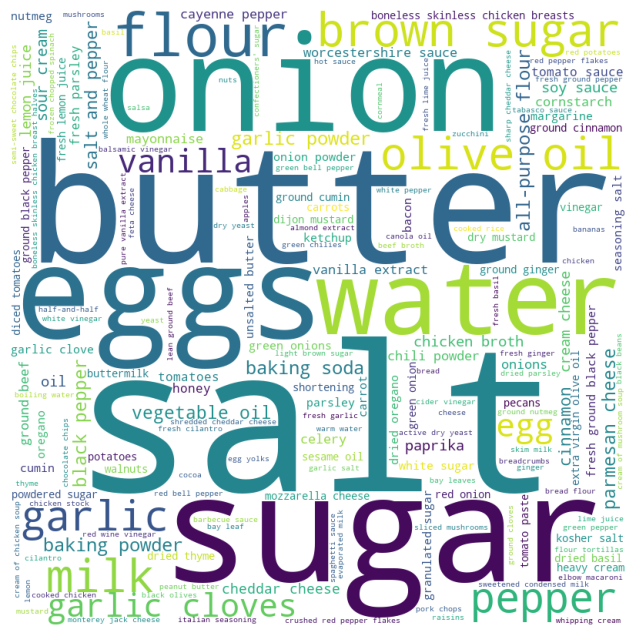

In [75]:
# Create dictionary from dataframe
word_dict = {}
for index, row in i.iterrows():
    word_dict[row['ingredients']] = row['recipe_id']

# Generate wordcloud from dictionary
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(word_dict)

# Plot the wordcloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout 

# Show the plot
plt.show()

### Train & Test Split

>This process is for dividing a dataset, referred to as `final_basetable`, into `training`, `testing`, and `validation` subsets. Initially, the dataset is split into train and test sets with `70%` of the data allocated to training and `30%` to testing, using a `train_test_split` function with a random_state of `42` for reproducibility. Subsequently, the training set is further divided, allocating `80%` of its data to a new training set and `20%` to a validation set, again using the same train_test_split function and random_state. After these splits, the indices of each DataFrame—train, test, and validation—are reset to ensure they are clean and sequential from zero without gaps. 

In [36]:
# split data into train and test sets (considering 70% for train set and 30% for test set)
train, test = train_test_split(final_basetable, test_size=0.3, random_state=42)

# split train data into train and validation sets (considering 50% for train set and 20% for test set)
train, val = train_test_split(train, test_size=0.2, random_state=42)

# reset index for all dataframes
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

print(final_basetable.shape)
print(train.shape)
print(test.shape)
print(val.shape)

(9428, 24)
(5279, 24)
(2829, 24)
(1320, 24)


In [40]:
def first_table(data):
    data=data[['user_id','ingredients','rating']]
    data = data.groupby(['user_id', 'ingredients'])['rating'].last().reset_index()
    data['ingredients'] = data['ingredients'].apply(ast.literal_eval)
    data = data.explode('ingredients')
    data=data.reset_index(drop=True)
    return data

In [41]:
# Applying the function of user item rating (first table)
train_t1=first_table(train)
val_t1=first_table(val)
test_t1=first_table(test)

print(train_t1.shape)
print(val_t1.shape)
print(test_t1.shape)

(48227, 3)
(12030, 3)
(25754, 3)


## Collabrative Filter Approach

### User Based CF

- Data is loaded and formatted for the Surprise library, setting up training, validation, and test sets from DataFrame columns with user IDs, ingredients, and ratings.
- 
Hyperparamete Tunin: Usin ` RandomizedSearchC` V, the code tunes hyperparameters like the number of neighbors and similarity metrics over a specified number of iterations and cross-validation folds to optimize RMSE
- `
Model Trainig ad Evaluati`n: The best parameters found from tuning are used to retrain  **a KNNBasic mod** el, which is then evaluated on the test and validation sets to compute t **RMSE**S
- s: Outputs include the best parameters, default prediction behavior, and the percentage of predictions that w e "impossi e" due to data sparsing: The model is finalized with the best settings and trained on the full training set, ensuring readiness for operational use.

In [42]:
# Load the train and test datasets into Surprise format
reader = Reader(rating_scale=(1, 6))
train_data = Dataset.load_from_df(train_t1[['user_id', 'ingredients', 'rating']], reader)
trainset = train_data.build_full_trainset()
val_data = list(val_t1[['user_id', 'ingredients', 'rating']].itertuples(index=False, name=None))
test_data = list(test_t1[['user_id', 'ingredients', 'rating']].itertuples(index=False, name=None))

# Define the parameter distribution for tuning hyperparameters
param_dist = {'k': randint(10, 50),
              'sim_options': {'name': ['cosine', 'pearson'],
                              'user_based': [True],
                              'min_k': [1, 5],
                              'max_k': [25, 50]}}

# Create an instance of KNNBasic
ub = KNNBasic

# Perform random search to find the best hyperparameters using cross-validation
rs = RandomizedSearchCV(ub, param_distributions=param_dist, n_iter=2, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs.fit(train_data)

# Evaluate the model on the testing set
pred_val = rs.test(val_data)
pred_test = rs.test(test_data)
rmse_val = accuracy.rmse(pred_val)
rmse_test = accuracy.rmse(pred_test)

# Print the best parameters and RMSE score
print('Best Parameters: ', rs.best_params['rmse'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4675
RMSE: 1.4498
Best Parameters:  {'k': 38, 'sim_options': {'name': 'pearson', 'user_based': True, 'min_k': 5, 'max_k': 25}}


In [43]:
# Train the model with best parameters
model_ub = KNNBasic(k=48, sim_options={'name': 'cosine', 'user_based': True, 'min_k': 5, 'max_k': 50})
model_ub.fit(trainset)

# Get the default prediction for a user matrix
default_pred = model_ub.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test if i.details["was_impossible"]]) / len(pred_test)
print(f"Impossible for Test Set: {perc_impossible:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
5.380367843738984
Impossible for Test Set: 0.6377


In [44]:
# Inspect prediction output
pd.DataFrame(pred_test).sort_values(by='est', ascending=True).head(5)

,uid,iid,r_ui,est,details
22180,U8859819,water,6,1.0,"{'actual_k': 1, 'was_impossible': False}"
3857,U2282949,sugar,6,1.0,"{'actual_k': 1, 'was_impossible': False}"
7417,U3658698,pepperoni,6,1.0,"{'actual_k': 1, 'was_impossible': False}"
7416,U3658698,provolone cheese,6,1.0,"{'actual_k': 2, 'was_impossible': False}"
13883,U5949720,salt,6,1.0,"{'actual_k': 1, 'was_impossible': False}"


### Item Based CF

Describes the setup and execution of a machine learning pipeline using the Surprise library, specifically for a user-item recommendation system employing a KNNBasic algorithm

In [45]:
# Define the parameter distribution for tuning hyperparameters
param_dist = {'k': randint(10, 50),
              'sim_options': {'name': ['cosine', 'pearson'],
                              'user_based': [False],
                              'min_k': [1, 5],
                              'max_k': [25, 50]}}

# Create an instance of KNNBasic
ib = KNNBasic

# Perform random search to find the best hyperparameters using cross-validation
rs_ib = RandomizedSearchCV(ib, param_distributions=param_dist, n_iter=2, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs_ib.fit(train_data)

# Evaluate the model on the testing set
pred_val_ib = rs_ib.test(val_data)
pred_test_ib = rs_ib.test(test_data)
rmse_val = accuracy.rmse(pred_val)
rmse_test = accuracy.rmse(pred_test)

# Print the best parameters and RMSE score
print('Best Parameters: ', rs_ib.best_params['rmse'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4675
RMSE: 1.4498
Best Parameters:  {'k': 38, 'sim_options': {'name': 'pearson', 'user_based': False, 'min_k': 5, 'max_k': 25}}


Applying the best parameters identified from the hyper parameters applied to the user based collabrative filtering
`Best Parameters:  {'k': 38, 'sim_options': {'name': 'pearson', 'user_based': False, 'min_k': 5, 'max_k': 25}}`

In [46]:
# Train the model with best parameters
model_ib = KNNBasic(k=48, sim_options={'name': 'cosine', 'user_based': False, 'min_k': 5, 'max_k': 50})
model_ib.fit(trainset)

# Get the default prediction for a user matrix
default_pred = model_ib.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test_ib if i.details["was_impossible"]]) / len(pred_test_ib)
print(f"Impossible: {perc_impossible:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
5.380367843738984
Impossible: 0.2652


In [47]:
# Inspect prediction output
pd.DataFrame(pred_test_ib).sort_values(by='est', ascending=True).head(5)

,uid,iid,r_ui,est,details
22187,U8859819,fresh ground black pepper,6,1.0,"{'actual_k': 10, 'was_impossible': False}"
513,U1222870,worcestershire sauce,6,1.0,"{'actual_k': 7, 'was_impossible': False}"
514,U1222870,tomato sauce,6,1.0,"{'actual_k': 7, 'was_impossible': False}"
515,U1222870,paprika,6,1.0,"{'actual_k': 7, 'was_impossible': False}"
516,U1222870,oregano,6,1.0,"{'actual_k': 7, 'was_impossible': False}"


### Probabilistic matrix factorization (SVD)

A dictionary named param_dist is created, defining a range of values for various hyperparameters of the SVD algorithm, including **n_factors** (number of factors), **n_epochs** (number of iterations over the training data), **lr_all** (learning rate for all parameters), **reg_all** (regularization term for all parameters), and settings like `random_state`, `biased`, and `verbose`. An instance of the SVD class is defined, and RandomizedSearchCV is set up to perform a grid search over the defined parameter space. The search is conducted with` 5 iteration`s and` 3-fold cross-validatio`n, targeting the root mean square error (RMSE) as the evaluation metric. The refit=True parameter ensures that once the best hyperparameters are found, the model is refit on the entire training set using those parameters: The best-fit model from the grid search is then used to make predictions on both validation (val_data) and test (test_data) datasets. The RMSE for each dataset is calculated to assess the accuracy of the model.

In [48]:
# Define the parameter grid for tuning hyperparameters
param_dist = {'n_factors': [10, 20, 30],
              'n_epochs': [10, 20, 30],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.1, 0.4],
              'random_state' : [42],
              'biased': [True],
              'verbose': [False]}

# Create an instance of SVD
svd = SVD

# Perform grid search to find the best hyperparameters using cross-validation
rs_svd = RandomizedSearchCV(svd, param_distributions=param_dist, n_iter=5, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs_svd.fit(train_data)

# Evaluate the model on the testing set
pred_val_svd = rs_svd.test(val_data)
pred_test_svd = rs_svd.test(test_data)
rmse_val = accuracy.rmse(pred_val)
rmse_test = accuracy.rmse(pred_test)

# Print the best hyperparameters and RMSE score
print('Best Parameters: ', rs_svd.best_params['rmse'])

RMSE: 1.4675
RMSE: 1.4498
Best Parameters:  {'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1, 'random_state': 42, 'biased': True, 'verbose': False}


The Best Parameter Based on the Hyper Parameter applied on svd is `{'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1, 'random_state': 42, 'biased': True, 'verbose': False}`

In [49]:
# Fit the model on the training set with the best hyperparameters
svd = SVD(n_factors=rs_svd.best_params['rmse']['n_factors'], 
          n_epochs=rs_svd.best_params['rmse']['n_epochs'], 
          lr_all=rs_svd.best_params['rmse']['lr_all'], 
          reg_all=rs_svd.best_params['rmse']['reg_all'],
          random_state=42)
svd.fit(trainset)

# Get the default prediction for a user matrix
default_pred = svd.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test_svd if i.details["was_impossible"]]) / len(pred_test_svd)
print(f"Impossible: {perc_impossible:.4f}")

5.380367843738984
Impossible: 0.0000


In [50]:
# Inspect prediction output
pd.DataFrame(pred_test_svd).sort_values(by='est', ascending=True).head(5)

,uid,iid,r_ui,est,details
22176,U8859819,red chili powder,6,1.150672,{'was_impossible': False}
3749,U2262460,spaghetti,5,1.185619,{'was_impossible': False}
2531,U1826179,blueberries,6,1.276238,{'was_impossible': False}
22996,U9113795,cinnamon,6,1.305563,{'was_impossible': False}
22990,U9113795,vanilla,6,1.309976,{'was_impossible': False}


### ALS

A parameter grid param_dist is defined specifically for the baseline model, focusing on the alternating least squares (ALS) method. Parameters such as n_epochs (number of epochs to run ALS), reg_u (regularization parameter for users), reg_i (regularization parameter for items), and verbose for logging the training process are specified. random_state ensures reproducibility in results. 
An instance of BaselineOnly is created, and RandomizedSearchCV is used to perform a grid search. This search, set to ru`n` 8 iterations with 3-fold cross-validation, aims to find the best hyperparameters based on the root mean square error (RMSE) metric. The model is refitted with the best parameters on the full training s`t (refit=Tru`e).

In [51]:
# Define the parameter grid for tuning hyperparameters
param_dist = {'bsl_options': {'method': ['als'], 
                              'n_epochs': [20, 30],
                              'reg_u': [10, 15],
                              'reg_i': [5, 10],
                              'verbose': [True],
                              'random_state': [42]}}

# Create an instance of BaselineOnly
als = BaselineOnly

# Perform grid search to find the best hyperparameters using cross-validation
rs_als = RandomizedSearchCV(als, param_distributions=param_dist, n_iter=8, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs_als.fit(train_data)

# Evaluate the model on the testing set
pred_val_als = rs_als.test(val_data)
pred_test_als = rs_als.test(test_data)
rmse_val = accuracy.rmse(pred_val_als)
rmse_test = accuracy.rmse(pred_test_als)

# Print the best parameters and RMSE score
print('Best Parameters: ', rs_als.best_params['rmse'])

Estimating biases using als...
RMSE: 1.4828
RMSE: 1.4158
Best Parameters:  {'bsl_options': {'method': 'als', 'n_epochs': 20, 'reg_u': 10, 'reg_i': 10, 'verbose': True, 'random_state': 42}}


The Best Parameters for **ALS** is `{'bsl_options': {'method': 'als', 'n_epochs': 20, 'reg_u': 10, 'reg_i': 10, 'verbose': True, 'random_state': 42}}`

In [52]:
# Fit the model on the training set with the best hyperparameters

options = {"method": "als", "n_epochs": 30, 'reg_u': 10, 'reg_i': 10, 'verbose': True, 'random_state': 42}
als = BaselineOnly(bsl_options=options)
trainset = train_data.build_full_trainset()
als.fit(trainset)

# Get the default prediction for a user matrix
default_pred = als.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test_als if i.details["was_impossible"]]) / len(pred_test_als)
print(f"Impossible: {perc_impossible:.4f}")

Estimating biases using als...
5.380367843738984
Impossible: 0.0000


### Co Clustring

An instance of CoClustering is created. RandomizedSearchCV is then used to conduct a randomized search over the defined hyperparameter space, configured to perform 8 iterations with 3-fold cross-validation. The search focuses on optimizing the root mean square error (RMSE), with refit=True ensuring that the best model is retrained on the entire training dataset. param_dist sets the hyperparameter ranges for the CoClustering model, including the number of user clusters **(n_cltr_u)**, item clusters **(n_cltr_i)**, and the number of training epochs **(n_epochs)**. random_state is set to ensure reproducible results across runs.


In [53]:
# Define the parameter distribution for tuning hyperparameters
param_dist = {'n_cltr_u': [3, 5, 10],
              'n_cltr_i': [3, 5, 10],
              'n_epochs': [20, 30, 50],
              'random_state': [42]}

# Create an instance of CoClustering
clust = CoClustering

# Perform random search to find the best hyperparameters using cross-validation
rs_clust = RandomizedSearchCV(clust, param_distributions=param_dist, n_iter=8, cv=3, n_jobs=-1, measures=['rmse'], random_state=42, refit=True)
rs_clust.fit(train_data)

# Evaluate the model on the testing set
pred_val_clust = rs_clust.test(val_data)
pred_test_clust = rs_clust.test(test_data)
rmse_val = accuracy.rmse(pred_val_clust)
rmse_test = accuracy.rmse(pred_test_clust)

# Print the best parameters and RMSE score
print('Best Parameters: ', rs_clust.best_params['rmse'])

RMSE: 1.6756
RMSE: 1.5891
Best Parameters:  {'n_cltr_u': 5, 'n_cltr_i': 3, 'n_epochs': 30, 'random_state': 42}


The Best Hyper Parameter selected for co clustring is `{'n_cltr_u': 5, 'n_cltr_i': 3, 'n_epochs': 30, 'random_state': 42}`

In [54]:
# Fit the model on the training set with the best hyperparameters
clust = CoClustering(n_cltr_u=rs_clust.best_params['rmse']['n_cltr_u'], 
                     n_cltr_i=rs_clust.best_params['rmse']['n_cltr_i'], 
                     n_epochs=rs_clust.best_params['rmse']['n_epochs'], 
                     random_state=42)
trainset = train_data.build_full_trainset()
clust.fit(trainset)

# Get the default prediction for a user matrix
default_pred = clust.default_prediction()
print(default_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred_test_clust if i.details["was_impossible"]]) / len(pred_test_clust)
print(f"Impossible: {perc_impossible:.4f}")

5.380367843738984
Impossible: 0.0000


### Evaluation 

Now we are comparing the each and every model with evaluation metrix such as `RMSE`,`MAE`,`Recall`,`Precision`,`F1`,`NDCG@5`

In [55]:
models = {"UB":model_ub, "IB":model_ib, "SVD":svd, "ALS":als, "Clust":clust}
overview = pd.concat([eval.evaluate(model.test(test_data), topn=5, rating_cutoff=4) for model in models.values()], axis=1)
overview.columns = list(models.keys())
overview

,UB,IB,SVD,ALS,Clust
RMSE,1.380989,1.562389,1.480018,1.415758,1.589144
MAE,0.854335,0.886318,0.891975,0.888423,0.914463
Recall,0.995610,0.939647,0.949791,0.967607,0.927372
Precision,0.911037,0.914886,0.915041,0.913525,0.915741
F1,0.951448,0.927101,0.932092,0.939788,0.921520
NDCG@5,0.876234,0.912064,0.841619,0.838546,0.899333


## Top N Recommendations

In [56]:
final_basetable['user_id'].value_counts()

U6596064    14
U5506671    14
U2013744    14
U6069719    14
U4373842    13
            ..
U7409308     1
U9136566     1
U1522674     1
U3792472     1
U1094413     1
Name: user_id, Length: 3106, dtype: int64

**Function**: topn(model, train, user, topk=5, item_col='recipe_id')
- **Important Keys**:
  - model: The recommendation model used for prediction.
  - train: Training data containing user-item interactions.
  - user: ID of the user for whom recommendations are generated.
  - topk: Number of top recommendations to be generated.
  - item_col: Name of the column representing items in the training data.

>The topn function generates top recommendations for a user based on a model and training data.A loop iterates through different recommendation models, calling topn for each.Recommendations are stored in a dictionary with model names as keys.Results are converted into a DataFrame for easy comparison.

In [58]:
def topn(model, train, user, topk=5, item_col='recipe_id'):
    # intermediate result dict 
    res = {item_col:[], 'pred':[], 'detail':[]}
    
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        # if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)

    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

In [59]:
# Top 10 recommendations for user "U6596064"
user = "U6596064"
topk = 10

lookup_ingredient = train_t1.drop_duplicates(subset=["ingredients"], keep="last").set_index("ingredients")

res = {}
for model_name, model in dict(user_based=model_ub, item_based=model_ib, als=als, svd=svd, coclustering=clust).items():
    pred = topn(model, train_t1, user=user, topk=topk, item_col="ingredients")

    # get name for each of the predicted product ids
    pred_name = [lookup_ingredient.loc[i].name for i in pred]
    res[model_name] = pred_name
 
pd.DataFrame(res)

,user_based,item_based,als,svd,coclustering
0,vanilla ice cream,cardamom,cake mix,fresh peach,crab claw meat
1,cheese-filled egg tortellini,sirloin,dried rubbed sage,dried rubbed sage,seedless european cucumber
2,baking mix,mccormick's montreal brand steak seasoning,pizza crust,olive oil flavored cooking spray,tuna steaks
3,brie cheese,cream cheese with chives,lemon-pepper seasoning,pizza crust,frozen baby peas
4,chocolate syrup,pear juice,cool whip,racks of baby-back pork ribs,caraway seeds
5,mixed vegetables,genoa salami,olive oil flavored cooking spray,granulated garlic,hard salami
6,nonfat beef broth,mexican-style corn,black peppercorns,marinated artichoke hearts,bourbon
7,fruit preserves,kiwi fruits,granulated garlic,spicy brown mustard,chipotle pepper
8,wonton wrappers,red delicious apples,fresh peach,white candy coating,raw cauliflower
9,buckwheat flour,dried herbs,spicy brown mustard,green food coloring,apple butter


## Ingredient Match Count Calculation
- *Objective:* Calculate the number of ingredient matches between two lists.
- *Function:* ingredient_match_count(ingredients_list1, ingredients_list2).
- *Description:* Iterates through the ingredients in one list and checks for matches in the other list, incrementing a counter for each match.

## Top Items Recommendation
- *Objective:* Recommend top items for a specified user.
- *Function:* topn(model, train, user, topk, item_col).
- *Description:* Utilizes a collaborative filtering model to recommend top items based on user preferences.

## Matching Recipe Names
- *Objective:* Find recipe names matching the recommended items.
- *Description:* Iterates through the recommended items, matches their ingredients with those in the dataset, and retrieves corresponding recipe names.

In [60]:
# Define a function to calculate the number of ingredient matches
def ingredient_match_count(ingredients_list1, ingredients_list2):
    match_count = 0
    for ingredient in ingredients_list1:
        if ingredient in ingredients_list2:
            match_count += 1
    return match_count

# Call the 'topn' function to get the list of top items for the specified user
model = model_ub
user = 'U6596064'  # The user ID for which you want to get item IDs
top_items = topn(model=model, train=train, user=user, topk=10, item_col='ingredients')

# Create a set to store unique matched recipe names
matched_recipe_names = set()

# Iterate through the top_items list and find the corresponding recipe names in 'base_df'
for item in top_items:
    item_ingredients = item.split(', ')  # Split the item's ingredients into a list
    for index, row in final_basetable.iterrows():
        base_ingredients = row['ingredients']
        match_count = ingredient_match_count(item_ingredients, base_ingredients)
        if match_count ==1:
            matched_recipe_names.add(row['name'])

# Print the unique matched recipe names
print("Matched Recipe Names: ")
for name in matched_recipe_names:
    print(name)

Matched Recipe Names: 
how to make baked taco salad shell bowls
hungarian goulash
my favorite chili
crook s corner shrimp and grits
wonderful salsa
beef and broccoli
kittencal s slow cooker eye of round roast with gravy
chile vinegar turnip greens
lisa s swirled chocolate chip cookies
the  blue mill tavern loosemeat sandwich
chinese wontons
snickerdoodle blondies
pizza dough for pizza or calzones  bread machine
sweet salsa dump chicken   oamc
slow cooked bbq ribs  for crock pot
kittencal s taco seasoning mix
tex mex rice
honey baked lentils
mexican fish
blueberries and cream ice cream
chicken thigh spareribs well  sort of  lol
decked out burgers
silky vanilla butter frosting
creamed cabbage  norwegian style
cherry time cobbler
weight watchers general tso s chicken
quick soft breadsticks
kittencal s marinade for grilled steak
big thicket chicken and dumplings
vanilla  buttercream frosting  from sprinkles cupcakes
best cherry pie
pasta sauce  1
tsr version of jimmy dean pork breakfast sa

In [61]:
# unnest the lists in the "ingredients" column
fin_base = final_basetable[["ingredients", "healthy"]]
fin_base['ingredients'] = fin_base['ingredients'].apply(ast.literal_eval)
fin_base = fin_base.explode("ingredients")

# group the data by the "healthy" column and get the unique ingredients for each group
healthy_ingredients = fin_base[fin_base["healthy"] == 1]["ingredients"].unique().tolist()
non_healthy_ingredients = fin_base[fin_base["healthy"] == 0]["ingredients"].unique().tolist()

In [63]:
# match the healthy and non-healthy ingredients with the unique ingredient list
healthy = [ingredient for ingredient in ingredients_list if ingredient in healthy_ingredients]
non_healthy= [ingredient for ingredient in ingredients_list if ingredient in non_healthy_ingredients]

print("Healthy ingredients:", healthy)
print("Non-healthy ingredients:", non_healthy)

Healthy ingredients: ['salt', 'butter', 'sugar', 'onion', 'eggs', 'water', 'flour', 'brown sugar', 'milk', 'olive oil', 'garlic', 'pepper', 'garlic cloves', 'vanilla', 'egg', 'baking powder', 'all-purpose flour', 'baking soda', 'garlic powder', 'parmesan cheese', 'vegetable oil', 'black pepper', 'salt and pepper', 'cinnamon', 'sour cream', 'cream cheese', 'oil', 'chicken broth', 'lemon juice', 'paprika', 'soy sauce', 'cheddar cheese', 'worcestershire sauce', 'mayonnaise', 'cornstarch', 'vanilla extract', 'onions', 'cayenne pepper', 'celery', 'ground beef', 'chili powder', 'fresh parsley', 'tomatoes', 'honey', 'tomato sauce', 'carrot', 'granulated sugar', 'dried oregano', 'margarine', 'fresh ground black pepper', 'bacon', 'oregano', 'green onions', 'onion powder', 'seasoning salt', 'garlic clove', 'white sugar', 'cumin', 'ketchup', 'parsley', 'unsalted butter', 'nutmeg', 'boneless skinless chicken breasts', 'mozzarella cheese', 'extra virgin olive oil', 'potatoes', 'ground cinnamon', 'g

## Ingredient Healthiness Classification
- *Objective:* Classify ingredients as healthy or unhealthy.
- *Description:* Determines the healthiness of each ingredient based on predefined lists of healthy and unhealthy ingredients.

## Healthier Alternative Recommendation
- *Objective:* Recommend healthier alternatives for unhealthy ingredients.
- *Description:* Generates alternative recommendations for unhealthy ingredients by selecting from a list of healthier options, aiming to improve overall recipe healthiness.

## Recommended Ingredients Healthiness Evaluation
- *Objective:* Evaluate the healthiness of recommended ingredients.
- *Description:* Assesses the healthiness status of recommended ingredients and suggests alternatives for unhealthy ones, promoting healthier dietary choices.

In [74]:
# Example lists of healthy and unhealthy ingredients
healthy_ingredients = healthy
unhealthy_ingredients = non_healthy

# Randomly select 70% of the healthy ingredients as a sample for alternatives
healthy_final_filtered = random.sample(healthy_ingredients, int(0.7 * len(healthy_ingredients)))

# Example recommended ingredients from your model
recommended_ingredients_als = ['extra virgin olive oil', 'cooked brown rice', 'jalapeno pepper', 'soya sauce', 'smoked sausage', 'cheddar cheese', 'mascarpone cheese', 'gingerroot', 'frozen orange juice concentrate', 'lemon wedges']

# Define a function to determine if an ingredient is healthy or unhealthy
def determine_ingredient_healthiness(ingredient):
    if ingredient in healthy_ingredients:
        return 'healthy'
    elif ingredient in unhealthy_ingredients:
        return 'unhealthy'
    else:
        return 'unknown'

# Define a function to recommend healthier alternatives for unhealthy ingredients
def recommend_healthier_alternatives(ingredient):
    if ingredient in unhealthy_ingredients:
        filtered_healthy_ingredients = [h for h in healthy_final_filtered if h not in recommended_ingredients_als]
        if filtered_healthy_ingredients:
            return f'{random.choice(filtered_healthy_ingredients)} (healthier alternative)'
        else:
            return 'no healthier alternative found'
    return ingredient

# Determine the healthiness of the recommended ingredients and recommend healthier alternatives for unhealthy ingredients
recommended_ingredients_healthiness = {}
for ingredient in recommended_ingredients_als:
    healthiness = determine_ingredient_healthiness(ingredient)
    if healthiness == 'unhealthy':
        recommended_ingredient = recommend_healthier_alternatives(ingredient)
    else:
        recommended_ingredient = ingredient
    recommended_ingredients_healthiness[ingredient] = (healthiness, recommended_ingredient)

# Print the recommended ingredients and their healthiness status and recommended alternatives
print('Recommendations for Healthy Ingredients:')
for ingredient, (healthiness, recommended_ingredient) in recommended_ingredients_healthiness.items():
    if recommended_ingredient != ingredient:
        print(f'{ingredient}: {healthiness} -> {recommended_ingredient}')
    else:
        print(f'{ingredient}: {healthiness}')

Recommendations for Healthy Ingredients:
extra virgin olive oil: healthy
cooked brown rice: healthy
jalapeno pepper: healthy
soya sauce: unhealthy -> pumpkin puree (healthier alternative)
smoked sausage: unhealthy -> lime zest (healthier alternative)
cheddar cheese: healthy
mascarpone cheese: unhealthy -> red beans (healthier alternative)
gingerroot: unhealthy -> red pepper flakes (healthier alternative)
frozen orange juice concentrate: unhealthy -> tomato paste (healthier alternative)
lemon wedges: unhealthy -> cream cheese frosting (healthier alternative)
